# Demixed PCA チュートリアル: 歩行ダイナミクス × メンタル状態

このノートブックでは、歩行ダイナミクスとメンタル状態（Wellbeingスコア等）の対応関係を分析します。

## 重要な前提

**メンタルスコア（Wellbeing等）の特性：**
- 各被験者/トライアルに対して**1つの固定値**
- **歩行周期（時間）に依存しない**
- 例：被験者Aのwellbeing = 7.5（歩行測定中ずっと一定）

```
┌─────────────────────────────────────────────────────────┐
│ 歩行データ: 時間とともに変化                              │
│   hip_flexion: ~~~~∿∿∿~~~~                             │
│   knee_flexion: ∿∿∿~~~~∿∿∿                             │
│                                                         │
│ Wellbeingスコア: 時間に依存せず一定                      │
│   score = 7.5 ─────────────────────────                │
│              0%        50%        100%                  │
│                    歩行周期                              │
└─────────────────────────────────────────────────────────┘
```

In [17]:
# セットアップ
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dpca import ContinuousScoreDPCA
from src.data_loader import GaitDataLoader

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("セットアップ完了！")

ImportError: cannot import name 'ContinuousScoreDPCA' from 'src.dpca' (/Users/hirotaiyohamada/Desktop/personal-project/gait_latent_dynamics/src/dpca.py)

## 1. データ構造の理解

### 歩行データ（時間依存）

| 次元 | 意味 | 例 |
|------|------|-----|
| n_subjects | 被験者数 | 30人 |
| n_features | 歩行特徴量 | 15個（関節角度、歩幅等） |
| n_timepoints | 歩行周期の時間点 | 100点（0-100%） |

```python
gait_data.shape = (30, 15, 100)  # 被験者 × 特徴量 × 時間
```

### メンタルスコア（時間に依存しない連続値）

| 変数 | 形状 | 特徴 |
|------|------|------|
| wellbeing_scores | (30,) | 各被験者に1つの値、歩行周期内で一定 |

```python
wellbeing_scores = [7.5, 4.2, 8.1, ...]  # 各被験者1つの値
```

### 歩行特徴量一覧

| 変数名 | 日本語 | 説明 |
|--------|--------|------|
| hip_flexion | 股関節屈曲 | 脚を前に振り出す角度 |
| hip_abduction | 股関節外転 | 脚を横に開く角度 |
| knee_flexion | 膝関節屈曲 | 膝の曲げ角度 |
| ankle_dorsiflexion | 足関節背屈 | 足首の角度 |
| pelvis_tilt | 骨盤前傾 | 骨盤の前後傾き |
| pelvis_obliquity | 骨盤傾斜 | 骨盤の左右傾き |
| trunk_flexion | 体幹屈曲 | 上半身の前後傾き |
| trunk_rotation | 体幹回旋 | 上半身のねじれ |
| stride_length | 歩幅 | 一歩の長さ |
| step_width | 歩隔 | 左右足の間隔 |
| cadence | ケイデンス | 歩行速度 |
| grf_vertical | 垂直地面反力 | 地面からの垂直力 |
| grf_anterior | 前後地面反力 | 推進・制動力 |
| grf_lateral | 左右地面反力 | 横方向の力 |
| com_velocity | 重心速度 | 身体重心の速度 |

# Demixed PCA チュートリアル: 歩行ダイナミクス × メンタル状態

このノートブックでは、demixed PCA (dPCA) を使用して歩行ダイナミクスとメンタル状態の対応関係を分析する方法を学びます。

## 目次
1. 導入とセットアップ
2. データの理解
3. dPCAの理論
4. 実践: dPCAの適用
5. 結果の解釈
6. 応用例

In [2]:
# セットアップ
import sys
from pathlib import Path

# プロジェクトルートをパスに追加
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# カスタムモジュール
from src.dpca import DemixedPCA, GaitDPCA
from src.data_loader import generate_synthetic_gait_data, GaitDataLoader
from src.visualization import DPCAVisualizer

# プロット設定
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Setup complete!")

Setup complete!


## 1. データの生成と理解

まず、合成歩行データを生成します。このデータは以下の特徴を持ちます：

- **特徴量**: 関節角度（股関節、膝、足首）、体幹の動き、歩行パラメータ（歩幅、ケイデンス等）、地面反力
- **時間**: 歩行周期（0-100%）
- **条件**: メンタル状態（neutral, anxious, relaxed, focused, fatigued）

In [3]:
# 合成データの生成
data, metadata = generate_synthetic_gait_data(
    n_trials=50,
    n_features=15,
    n_timepoints=100,
    n_conditions=5,
    mental_state_effect_strength=0.3,
    time_effect_strength=0.5,
    interaction_strength=0.15,
    noise_level=0.1,
    random_state=42
)

print(f"データ形状: {data.shape}")
print(f"  - トライアル数: {metadata['n_trials']}")
print(f"  - 特徴量数: {metadata['n_features']}")
print(f"  - 時間点数: {metadata['n_timepoints']}")
print(f"  - 条件数: {metadata['n_conditions']}")
print(f"\n特徴量: {metadata['feature_labels']}")
print(f"\nメンタル状態: {metadata['mental_state_labels']}")

データ形状: (50, 15, 100, 5)
  - トライアル数: 50
  - 特徴量数: 15
  - 時間点数: 100
  - 条件数: 5

特徴量: ['hip_flexion', 'hip_abduction', 'knee_flexion', 'ankle_dorsiflexion', 'pelvis_tilt', 'pelvis_obliquity', 'trunk_flexion', 'trunk_rotation', 'stride_length', 'step_width', 'cadence', 'grf_vertical', 'grf_anterior', 'grf_lateral', 'com_velocity']

メンタル状態: ['neutral', 'anxious', 'relaxed', 'focused', 'fatigued']


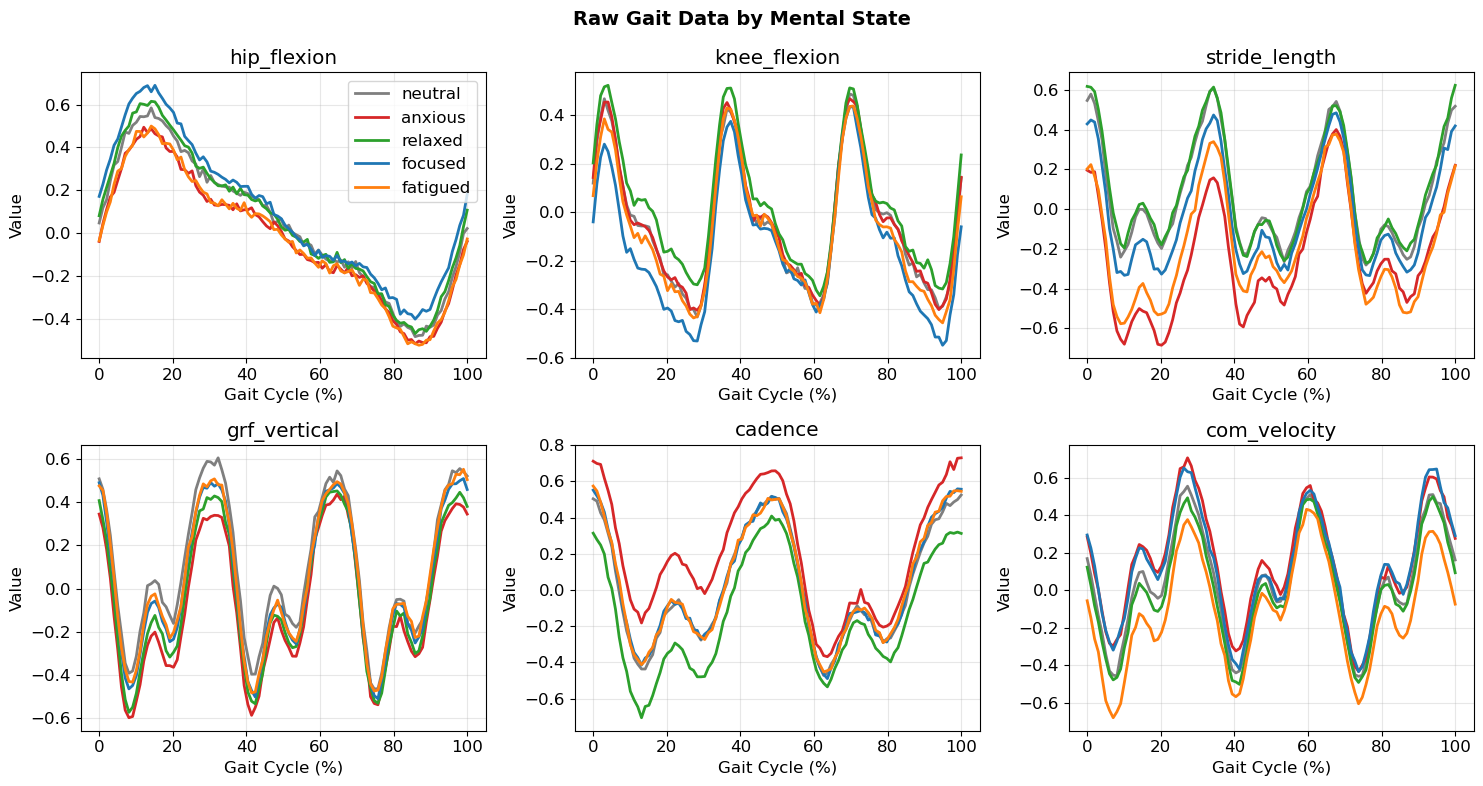

In [4]:
# データの可視化（生データ）
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

mental_states = metadata['mental_state_labels']
colors = ['#7f7f7f', '#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']
time_axis = np.linspace(0, 100, 100)

# トライアル平均
data_mean = data.mean(axis=0)

feature_indices = [0, 2, 8, 11, 10, 14]  # hip, knee, stride, grf_vertical, cadence, com
feature_names = [metadata['feature_labels'][i] for i in feature_indices]

for ax, f_idx, f_name in zip(axes.flat, feature_indices, feature_names):
    for c_idx, (state, color) in enumerate(zip(mental_states, colors)):
        ax.plot(time_axis, data_mean[f_idx, :, c_idx], label=state, color=color, linewidth=2)
    ax.set_title(f_name)
    ax.set_xlabel('Gait Cycle (%)')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

axes[0, 0].legend(loc='upper right')
plt.suptitle('Raw Gait Data by Mental State', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. dPCAの理論

### Demixed PCA とは？

標準的なPCAは分散を最大化する方向を見つけますが、その成分が何を表しているかは解釈が難しいです。

**dPCA**は、データの分散を異なる「ソース」に分解します：

1. **時間成分** (Time): 歩行周期に沿った変動（条件に関係なく共通のパターン）
2. **条件成分** (Condition/Mental State): メンタル状態による変動
3. **相互作用成分** (Interaction): 時間とメンタル状態の相互作用

### 数学的定式化

データ X を以下のように分解：

$$X_{fts} = \mu_f + \text{Time}_f(t) + \text{Condition}_f(s) + \text{Interaction}_f(t, s)$$

各成分に対して、その分散を最大化しつつ全体の共分散構造を考慮した射影方向を求めます。

## 3. データの前処理

In [5]:
# データの前処理
loader = GaitDataLoader()

# 正規化とフィルタリング
data_processed = loader.preprocess(
    data,
    normalize=True,       # Z-score正規化
    filter_cutoff=0.8,    # ローパスフィルタ
    resample_points=None  # リサンプリングなし
)

# トライアル平均
data_averaged = loader.get_trial_averaged_data(data_processed)

print(f"前処理後のデータ形状: {data_averaged.shape}")
print(f"  (n_features, n_timepoints, n_conditions)")

前処理後のデータ形状: (15, 100, 5)
  (n_features, n_timepoints, n_conditions)


## 4. dPCAの適用

In [6]:
# dPCAモデルの作成とフィッティング
dpca = DemixedPCA(
    n_components=10,       # 各marginalizationで抽出する成分数
    regularizer='auto'     # 正則化パラメータを自動決定
)

# フィット
dpca.fit(
    data_averaged,
    feature_labels=metadata['feature_labels'],
    marginalization_labels=['time', 'condition', 'interaction']
)

print("モデルのフィット完了！")
print(f"正則化パラメータ: {dpca._regularizer_value:.2e}")

モデルのフィット完了！
正則化パラメータ: 1.00e-10


In [7]:
# 分散分解のサマリー
summary = dpca.get_demixing_summary()

print("\n分散分解:")
print("-" * 40)
for name, var in summary.items():
    bar = '█' * int(var * 50)
    print(f"{name:15s} | {bar:50s} | {var:.1%}")


分散分解:
----------------------------------------
time            | ███████████████████████████████████                | 70.3%
condition       | ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 366.4%
interaction     | ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

## 5. 結果の可視化と解釈

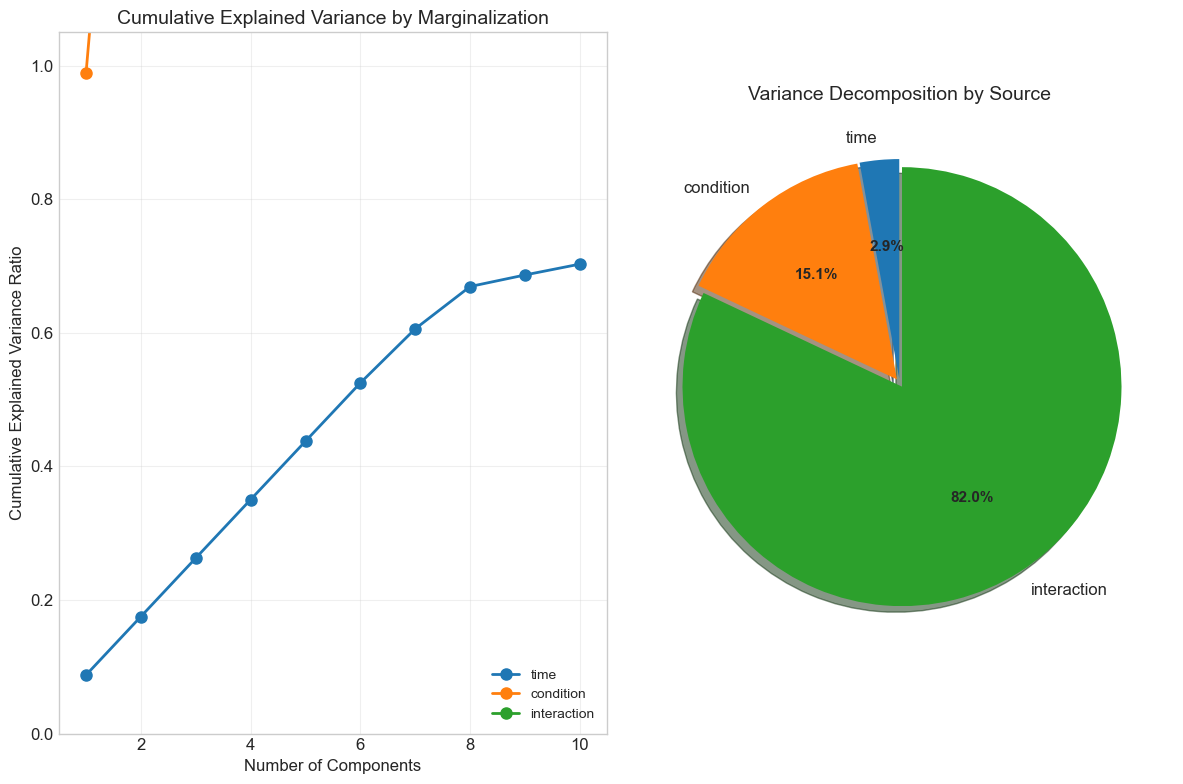

In [8]:
# 可視化オブジェクトの作成
viz = DPCAVisualizer()

# 説明分散比
fig = viz.plot_explained_variance(dpca)
plt.show()

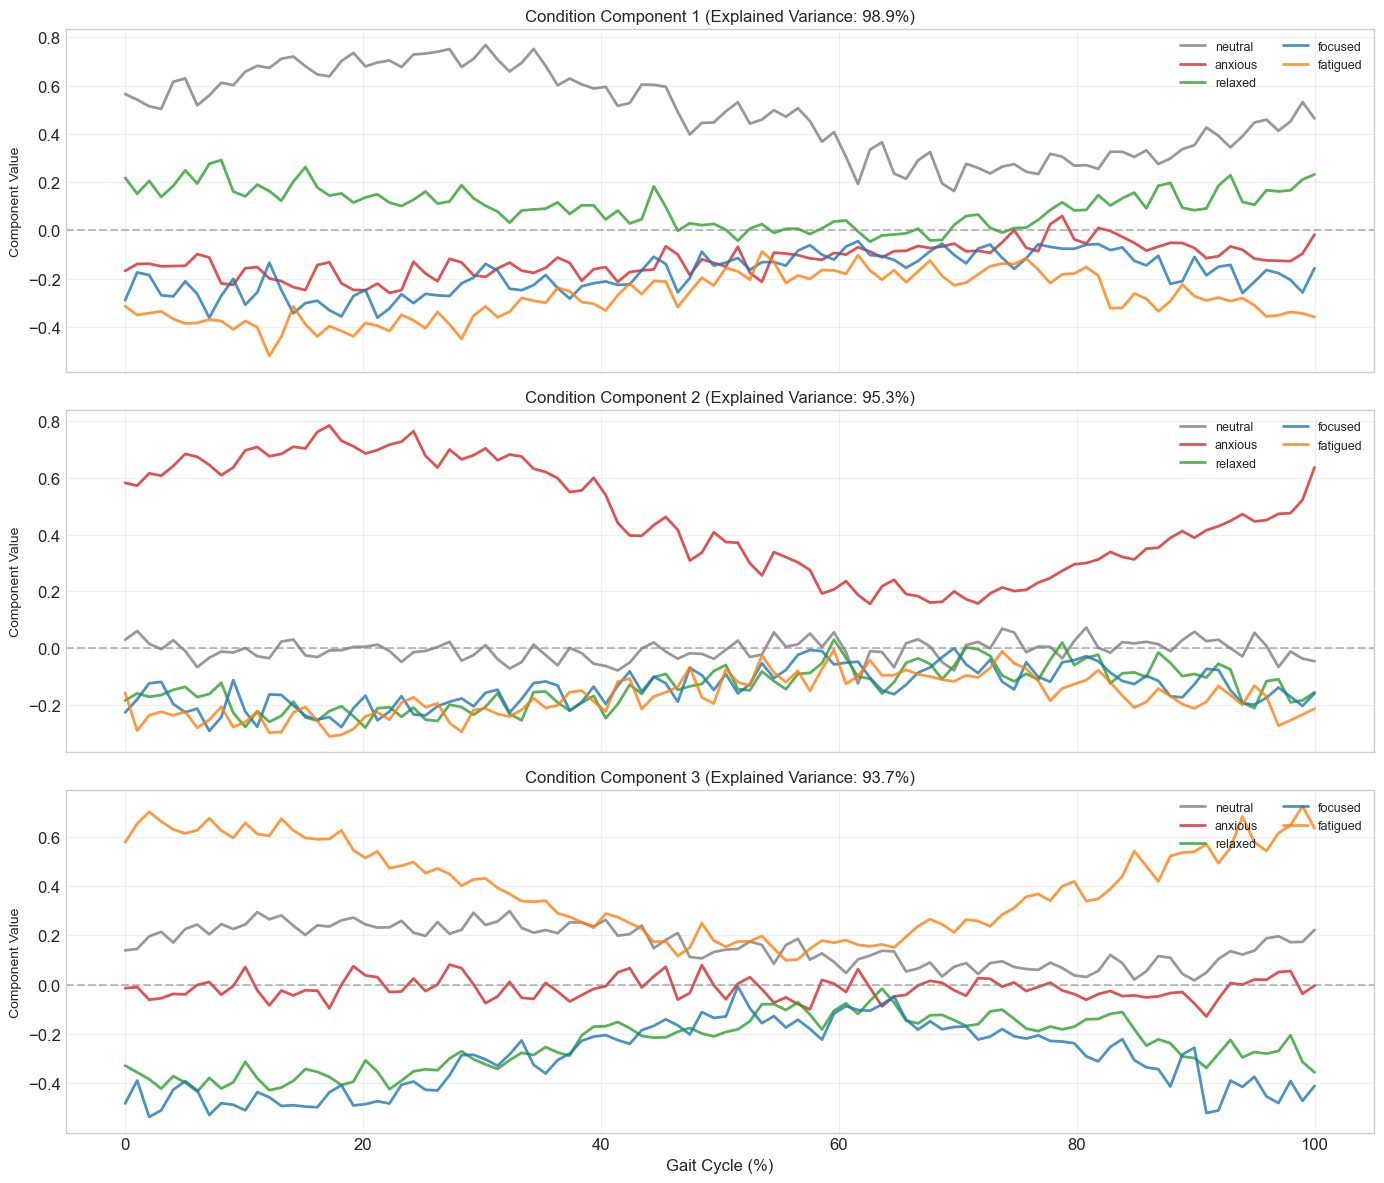

In [9]:
# 条件（メンタル状態）成分の時系列
fig = viz.plot_component_timecourse(
    dpca,
    data_averaged,
    marginalization='condition',
    components=[0, 1, 2],
    mental_state_labels=metadata['mental_state_labels']
)
plt.show()

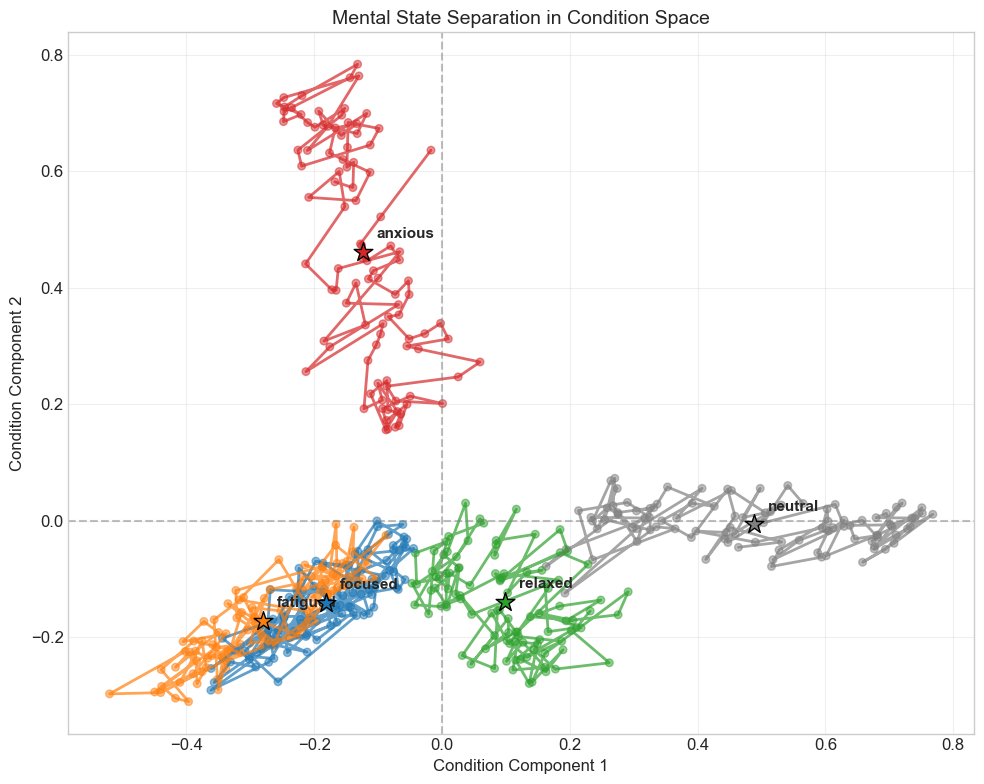

In [10]:
# メンタル状態の分離（2D射影）
fig = viz.plot_mental_state_separation(
    dpca,
    data_averaged,
    metadata['mental_state_labels'],
    marginalization='condition'
)
plt.show()

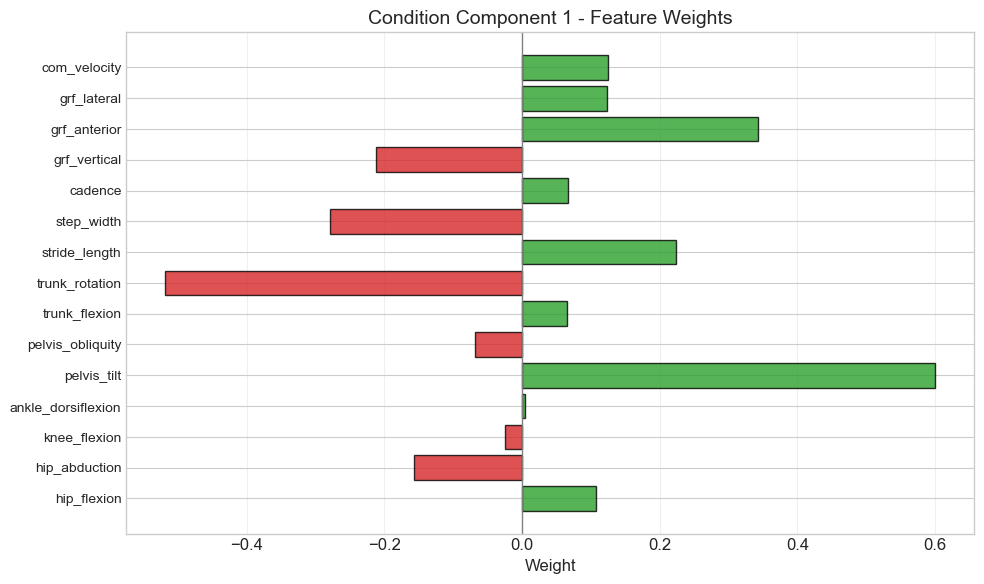

In [13]:
# 成分の重み（どの特徴量が各成分に寄与しているか）
fig = viz.plot_component_weights(
    dpca,
    marginalization='condition',
    component=0,
    feature_labels=metadata['feature_labels']
)
plt.show()

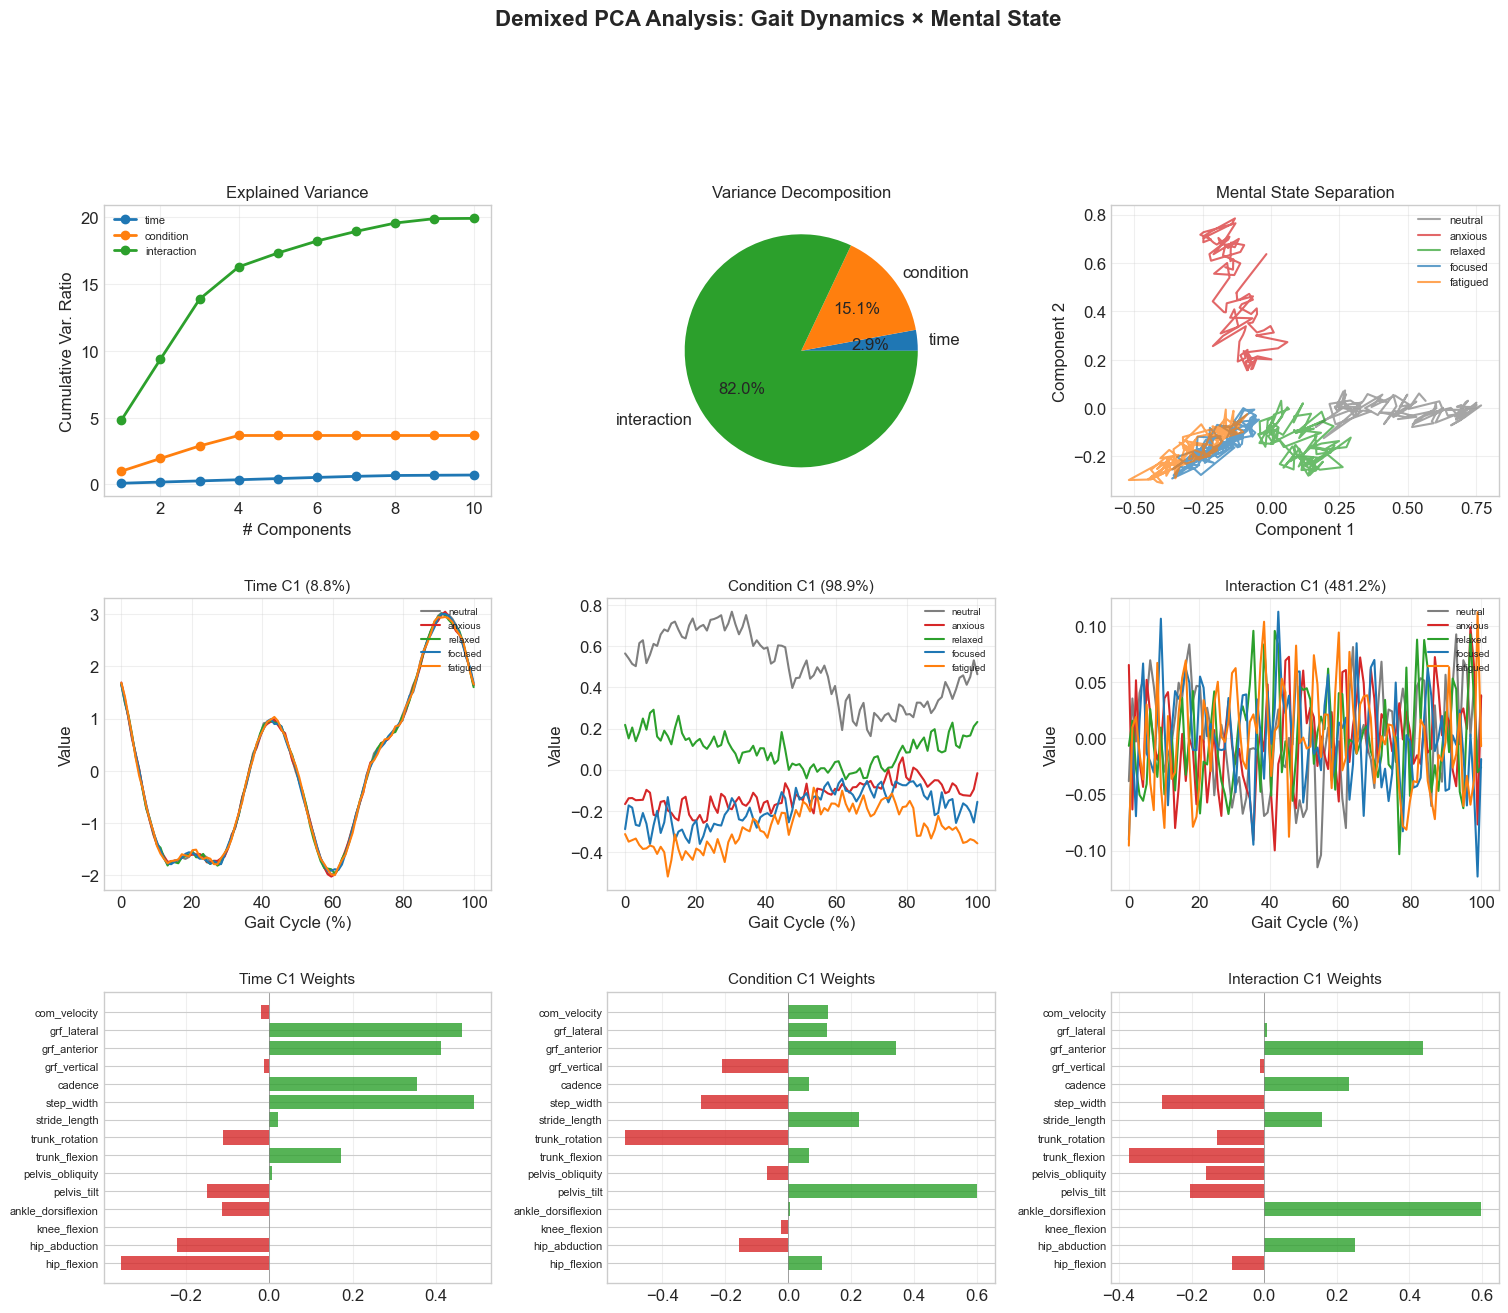

In [14]:
# 包括的なサマリープロット
fig = viz.plot_comprehensive_summary(
    dpca,
    data_averaged,
    metadata['mental_state_labels'],
    metadata['feature_labels']
)
plt.show()

## 6. メンタル状態の分離度分析

In [15]:
# GaitDPCAを使用した分離度分析
gait_dpca = GaitDPCA(n_components=10)
gait_dpca.fit_with_labels(
    data_averaged,
    mental_state_labels=metadata['mental_state_labels'],
    feature_labels=metadata['feature_labels']
)

# メンタル状態間の分離度を計算
separation_scores = gait_dpca.analyze_mental_state_separation(
    data_averaged,
    metadata['mental_state_labels']
)

print("\nメンタル状態間の分離度スコア:")
print("-" * 50)
sorted_scores = sorted(separation_scores.items(), key=lambda x: x[1], reverse=True)
for pair, score in sorted_scores:
    bar = '█' * int(score * 10)
    print(f"{pair:25s} | {bar:20s} | {score:.3f}")


メンタル状態間の分離度スコア:
--------------------------------------------------
neutral_vs_focused        | ████████             | 0.830
neutral_vs_fatigued       | ████████             | 0.829
neutral_vs_anxious        | ███████              | 0.797
fatigued_vs_anxious       | ███████              | 0.773
fatigued_vs_relaxed       | ███████              | 0.765
fatigued_vs_focused       | ███████              | 0.734
anxious_vs_relaxed        | ███████              | 0.704
anxious_vs_focused        | ██████               | 0.695
neutral_vs_relaxed        | ██████               | 0.642
relaxed_vs_focused        | ████                 | 0.465


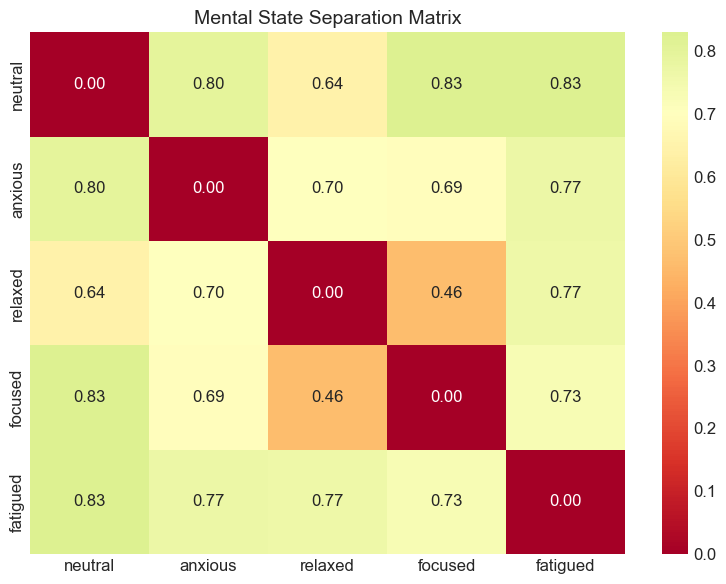

In [16]:
# 分離度をヒートマップで可視化
states = metadata['mental_state_labels']
n_states = len(states)
separation_matrix = np.zeros((n_states, n_states))

for pair, score in separation_scores.items():
    s1, s2 = pair.split('_vs_')
    i, j = states.index(s1), states.index(s2)
    separation_matrix[i, j] = score
    separation_matrix[j, i] = score

plt.figure(figsize=(8, 6))
sns.heatmap(
    separation_matrix,
    xticklabels=states,
    yticklabels=states,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=np.median(separation_matrix)
)
plt.title('Mental State Separation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## 7. まとめ

このチュートリアルでは、dPCAを使用して歩行ダイナミクスとメンタル状態の関係を分析しました。

### 主な発見:

1. **時間成分**: 歩行周期に沿った主要な運動パターンを捉えています
2. **条件成分**: メンタル状態による歩行の変化を反映しています
3. **相互作用成分**: メンタル状態によって歩行パターンの形状が変化する様子を示しています

### 応用:

- メンタルヘルスモニタリング
- 歩行リハビリテーション
- スポーツパフォーマンス分析
- 神経変性疾患の早期発見